In [143]:
%load_ext autoreload
%autoreload 2
import numpy as np
from obspy import UTCDateTime
from matplotlib import pyplot as plt
import ground_motion_qh
from ground_motion_qh.earthquake import EarthquakeCatalog
from ground_motion_qh.get_waveforms import get_stream_multiple_stations, raw_stream_to_amplitude_and_times
import os
from pathlib import Path
from pprint import pprint

base_dir = Path(ground_motion_qh.__file__).parent.parent

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [144]:
download_name = "ANZA_hero_run_1982_M35"

station_metadata = dict(
    stname = ["SND"],
    network = "AZ",
    org = "IRIS",
    latitude = 33.5519,
    longitude = -116.6129,
    start_time = '1982-10-01',
    number_of_tries = 2,
)

earthquake_metadata = {
    "starttime": '1994-01-01',
    "endtime": '2023-01-01',
    "latitude_range": [32,35],
    "longitude_range": [-117.5,-115.5],
    "minimum_magnitude": 3.5, 
}

# explanation of buffers:

# (hypocenter) t1                                                                                            t2
# t0 time shift    pre-buffer     event time window     mid buffer     forecast time window      post buffer
# |------------||--------------||-------------------||--------------||---------- ... ---------||-------------|

analysis_metadata = dict(
    mid_buffer = 10,
    forecast_time_window = 60*60,
    event_time_window = 30,
    shift_times = True,
)

analysis_metadata["pre_buffer"] = 0.05 * analysis_metadata["forecast_time_window"] + analysis_metadata["event_time_window"] + analysis_metadata["mid_buffer"]
analysis_metadata["post_buffer"] = 0.05 * analysis_metadata["forecast_time_window"] + analysis_metadata["event_time_window"] + analysis_metadata["mid_buffer"]


In [168]:
pprint(analysis_metadata, width=1)

{'event_time_window': 30,
 'forecast_time_window': 3600,
 'mid_buffer': 10,
 'post_buffer': 220.0,
 'pre_buffer': 220.0,
 'shift_times': True}


In [145]:
metadata = dict(
    earthquake_metadata = earthquake_metadata,
    analysis_metadata = analysis_metadata,
    station_metadata = station_metadata,
)
# create a data directory with and save the metadata
data_dir = base_dir / "data" / "raw_data" / download_name
os.makedirs(data_dir, exist_ok=True)
np.save(data_dir / "metadata.npy", metadata)

# to load the metadata
#metadata = np.load(data_dir / "metadata.npy", allow_pickle=True).item()

In [146]:
earthquakes = EarthquakeCatalog(
    filename=data_dir / "local_catalog.csv",
    kwargs=earthquake_metadata,
)

/Users/kdascher/Documents/Documents/USU/Projects/Exploratory_projects/GroundMotion_QH/ground_motion_qh/earthquake.py:196: UserWarning: Reloading /Users/kdascher/Documents/Documents/USU/Projects/Exploratory_projects/GroundMotion_QH/data/raw_data/ANZA_hero_run_1982_M35/local_catalog.csv
  warnings.warn(f"Reloading {filename}")


<Axes: xlabel='Time', ylabel='mag'>

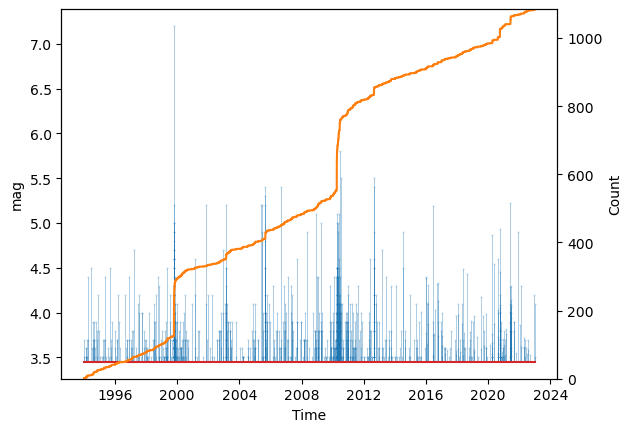

In [147]:
earthquakes.plot_time_series()

<GeoAxes: xlabel='Longitude', ylabel='Latitude'>

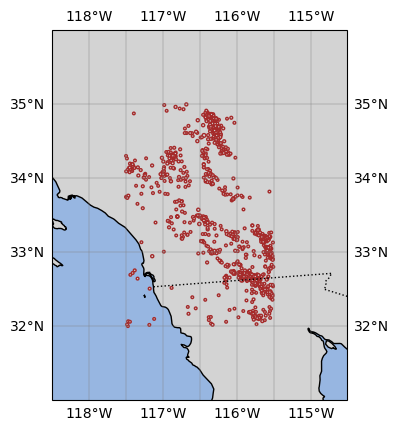

In [148]:
earthquakes.plot_map()

In [149]:
station_x, station_y, _, _ = earthquakes.get_utm_from_lonlat(station_metadata["longitude"], station_metadata["latitude"])
earthquakes_x, earthquakes_y, _, _ = earthquakes.get_utm_from_lonlat(earthquakes.catalog.lon.values, earthquakes.catalog.lat.values) 
distances = np.sqrt((earthquakes_x - station_x)**2 + (earthquakes_y - station_y)**2)

Text(0.5, 0, 'Station-Earhthquake distance (km)')

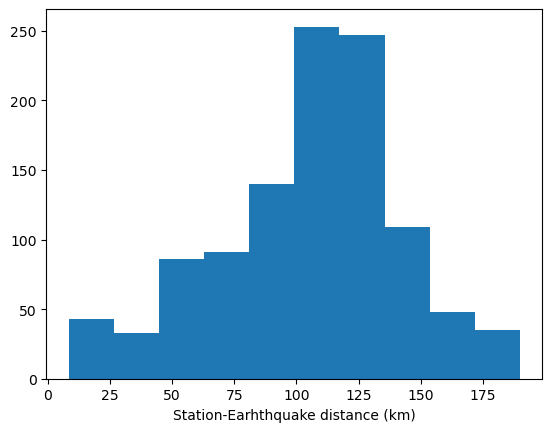

In [150]:
plt.hist(distances/1000)
plt.xlabel("Station-Earhthquake distance (km)")

In [151]:
minus_time_range = [
    analysis_metadata["pre_buffer"],
    analysis_metadata["pre_buffer"] + analysis_metadata["event_time_window"]
]

plus_time_range = [
    analysis_metadata["pre_buffer"] + analysis_metadata["event_time_window"],
    analysis_metadata["pre_buffer"] + analysis_metadata["event_time_window"] + analysis_metadata["mid_buffer"]
]


In [152]:
nominal_p_wave_speed = 7 # km/s

a_max_minus = []
a_max_plus = []

for i, (t0, distance) in enumerate(zip(earthquakes.catalog.time, distances)):
    print(f"Dowloading event {i}: {t0}")

    t1 = t0 + np.timedelta64(
        int(distance/nominal_p_wave_speed - analysis_metadata["pre_buffer"]),   # (QUAKE) HACK
        "s",
    )
    
    t2 = t1 + np.timedelta64(
        int(    # (QUAKE) HACK
            analysis_metadata["pre_buffer"] 
            + analysis_metadata["event_time_window"] 
            + analysis_metadata["mid_buffer"]
            + analysis_metadata["forecast_time_window"]
            + analysis_metadata["post_buffer"]
        ),
        "s",
    )
    
    # preprocess the waveforms
    i = 0
    while i < station_metadata["number_of_tries"]: 
        try:
            stream_dict = get_stream_multiple_stations(
                t1=UTCDateTime(t1),
                t2=UTCDateTime(t2),
            )
            amplitude, times = raw_stream_to_amplitude_and_times(stream_dict["SND"])

            event_dir = data_dir / f"data/{t1.strftime('%Y-%m-%d_%H-%M-%S')}"
            
            os.makedirs(event_dir, exist_ok=True)
            np.save(event_dir / "amplitude.npy", amplitude)
            np.save(event_dir / "times.npy", times)
            
            minus_time_range = [
                analysis_metadata["pre_buffer"],
                analysis_metadata["pre_buffer"] + analysis_metadata["event_time_window"]
            ]
            
            plus_time_range = [
                analysis_metadata["pre_buffer"] + analysis_metadata["event_time_window"],
                analysis_metadata["pre_buffer"] + analysis_metadata["event_time_window"] + analysis_metadata["mid_buffer"]
            ]
            
            a_minus = amplitude[(times >= minus_time_range[0]) & (times <= minus_time_range[1])]
            a_plus = amplitude[(times >= plus_time_range[0]) & (times <= plus_time_range[1])]
            
            a_max_minus.append(np.max(np.abs(a_minus - np.mean(a_minus))))
            a_max_plus.append(np.max(np.abs(a_plus - np.mean(a_plus))))                                    
        
        except Exception as e:
            print(f"Error dowloading event {i}: {e}")
        
        i+=1

Dowloading event 0: 1994-01-01 17:47:30.850000016
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 1: 1994-01-08 07:06:54.300000012
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 2: 1994-02-09 15:47:46.839999955
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 3: 1994-02-15 03:21:36.700000081
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No d

/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error dowloading event 0: zero-size array to reduction operation maximum which has no identity


/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error dowloading event 1: zero-size array to reduction operation maximum which has no identity
Dowloading event 10: 1994-06-16 16:24:26.200000045


/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error dowloading event 0: zero-size array to reduction operation maximum which has no identity


/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error dowloading event 1: zero-size array to reduction operation maximum which has no identity
Dowloading event 11: 1994-06-29 07:34:34.830000079
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 12: 1994-08-01 21:34:30.899999982
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 13: 1994-08-07 15:10:24.760000015
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 14: 1994-08-07 23:43:32.129999927
Error dowloading event 0: operands could 

/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error dowloading event 0: zero-size array to reduction operation maximum which has no identity


/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error dowloading event 1: zero-size array to reduction operation maximum which has no identity
Dowloading event 18: 1994-08-28 12:20:42.230000005


/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error dowloading event 0: zero-size array to reduction operation maximum which has no identity


/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error dowloading event 1: zero-size array to reduction operation maximum which has no identity
Dowloading event 19: 1994-09-12 00:16:58.719999961
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 20: 1994-10-09 04:10:06.750000024
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 21: 1994-11-07 18:32:20.119999974
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 22: 1994-11-09 02:29:04.200000074
Error dowloading event 0: No data availab

/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error dowloading event 0: zero-size array to reduction operation maximum which has no identity


/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error dowloading event 1: zero-size array to reduction operation maximum which has no identity
Dowloading event 26: 1995-01-24 11:57:28.319999883
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 27: 1995-02-19 15:47:58.009999781
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 28: 1995-04-04 05:08:15.409999942
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 29: 1995-04-04 06:26:49.389999777
Error dowloading event 0: No data availab

/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error dowloading event 0: zero-size array to reduction operation maximum which has no identity


/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error dowloading event 1: zero-size array to reduction operation maximum which has no identity
Dowloading event 32: 1995-05-13 02:25:21.730000010
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 33: 1995-06-09 19:44:03.990000235
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 34: 1995-07-28 07:07:30.019999794
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 35: 1995-08-06 11:22:23.600000029
Error dowloading event 0: No data availab

/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error dowloading event 0: zero-size array to reduction operation maximum which has no identity


/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error dowloading event 1: zero-size array to reduction operation maximum which has no identity
Dowloading event 40: 1995-10-22 14:41:03.019999925
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 41: 1995-12-25 23:40:07.539999790
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 42: 1996-01-05 11:57:40.359999931
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 43: 1996-01-25 05:35:12.469999983
Error dowloading event 0: No data availab

/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error dowloading event 0: zero-size array to reduction operation maximum which has no identity


/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error dowloading event 1: zero-size array to reduction operation maximum which has no identity
Dowloading event 46: 1996-03-01 09:50:41.999999953
Error dowloading event 0: operands could not be broadcast together with shapes (3950,) (4150,) 
Error dowloading event 1: operands could not be broadcast together with shapes (3950,) (4150,) 
Dowloading event 47: 1996-04-08 23:46:40.679999878
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 48: 1996-04-17 21:19:13.299999781
Error dowloading event 0: operands could not be broadcast together with shapes (2550,) (2500,) 
Error dowloading event 1: operands could not be broadcast together with shapes (2550,) (2500,) 
Dowloading event 49: 1996-08-14 03:05:26.789999907
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response 

/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error dowloading event 0: zero-size array to reduction operation maximum which has no identity


/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error dowloading event 1: zero-size array to reduction operation maximum which has no identity
Dowloading event 60: 1997-02-12 03:05:00.900000026
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 61: 1997-02-23 03:43:32.130000033
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 62: 1997-02-23 03:44:58.609999867
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 63: 1997-03-18 15:24:46.549999895
Error dowloading event 0: No data availab

/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error dowloading event 0: zero-size array to reduction operation maximum which has no identity


/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error dowloading event 1: zero-size array to reduction operation maximum which has no identity
Dowloading event 65: 1997-05-23 14:38:41.210000085
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 66: 1997-06-23 07:57:29.050000004
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 67: 1997-06-28 21:45:23.420000171
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 68: 1997-07-26 03:14:55.229999824
Error dowloading event 0: operands could 

/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error dowloading event 0: zero-size array to reduction operation maximum which has no identity


/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error dowloading event 1: zero-size array to reduction operation maximum which has no identity
Dowloading event 70: 1997-08-22 19:46:22.200000116
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 71: 1997-09-19 22:37:13.709999959
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 72: 1997-09-28 15:57:22.230000051
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 73: 1997-11-04 14:36:20.959999989


/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error dowloading event 0: zero-size array to reduction operation maximum which has no identity


/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kdascher/miniforge3/envs/wave2wave/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error dowloading event 1: zero-size array to reduction operation maximum which has no identity
Dowloading event 74: 1997-11-06 04:33:42.509999972
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 75: 1997-12-05 17:04:38.120000171
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 76: 1997-12-26 15:05:31.249999953
Error dowloading event 0: No data available for request.
HTTP Status code: 204
Detailed response of server:


Error dowloading event 1: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 77: 1997-12-27 16:56:40.169999904
Error dowloading event 0: operands could 

In [153]:
np.save(data_dir / "a_max_minus.npy", np.array(a_max_minus))
np.save(data_dir / "a_max_plus.npy", np.array(a_max_plus))

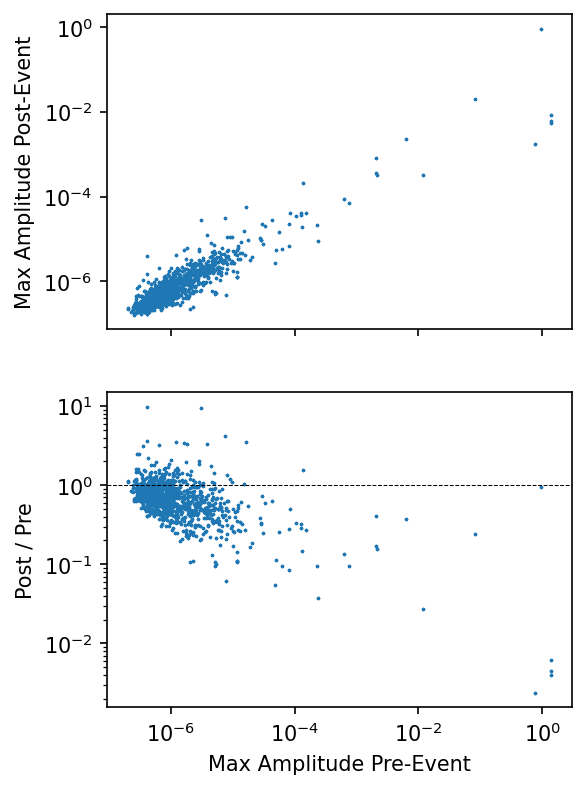

In [166]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(4, 6), dpi=150)
ax[0].scatter(np.array(a_max_minus), np.array(a_max_plus), s=0.5)
ax[0].set(
    xscale="log", 
    yscale="log",
    ylabel="Max Amplitude Post-Event",
)

ax[1].scatter(np.array(a_max_minus), np.array(a_max_plus)/np.array(a_max_minus), s=0.5)
ax[1].set(
    xscale="log", 
    yscale="log",
    xlabel="Max Amplitude Pre-Event",
    ylabel="Post / Pre",
)
ax[1].axhline(1, color="k", linestyle="--", lw=0.5)



In [154]:
# This goes in analysis file

# for each file in REPO 

# load stream

# split into parts

# calculate shaking intensity (e.g. PGV)